# Bitcoin OTC Network

In [1]:
import networkx as nx
import pandas as pd
import igraph
import datetime
import math
import operator
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw
import nltk
import random
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import igraph
from igraph import *
import community

In [2]:
df = pd.read_csv("soc-sign-bitcoinotc.csv",header=None,names=("SOURCE TARGET RATING TIME").split())
df.head(5)

,SOURCE,TARGET,RATING,TIME
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [3]:
def readable_time(time):
    r_time=datetime.datetime.fromtimestamp(time)
    return r_time

df["TIME"]=df["TIME"].apply(readable_time)
df.head(5)

,SOURCE,TARGET,RATING,TIME
0,6,2,4,2010-11-08 19:45:11.728360
1,6,5,2,2010-11-08 19:45:41.533780
2,1,15,1,2010-11-08 20:05:40.390490
3,4,3,7,2010-11-08 20:41:17.369750
4,13,16,8,2010-11-08 23:10:54.447460


In [4]:
G = nx.DiGraph()

f = open("soc-sign-bitcoinotc.csv","r")
for l in f:
    ls = l.strip().split(",")
    G.add_edge(ls[0], ls[1], weight = float(ls[2])) ## the weight should already be in the range of -1 to 1
f.close()

In [5]:
G.number_of_nodes()

5881

In [6]:
nx.is_directed(G)

True

In [356]:
size_Gcc

4709

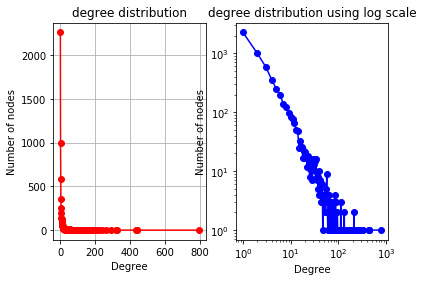

In [317]:
degrees=G.degree()
values= sorted(set(dict(degrees).values()))
#print(values)
hist=[list(dict(degrees).values()).count(x) for x in values]

plt.figure()
plt.subplot(1,2,1)
plt.grid(True)
plt.plot(values,hist, 'ro-') 
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('degree distribution')
plt.subplot(1,2,2)
plt.loglog(values,hist, 'bo-')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('degree distribution using log scale')
plt.show()

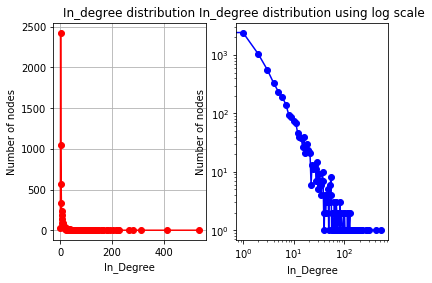

In [7]:
#In degree distribution
indegrees=G.in_degree()
values= sorted(set(dict(indegrees).values()))
#print(values)
hist=[list(dict(indegrees).values()).count(x) for x in values]

plt.figure()
plt.subplot(1,2,1)
plt.grid(True)
plt.plot(values,hist, 'ro-') 
plt.xlabel('In_Degree')
plt.ylabel('Number of nodes')
plt.title('In_degree distribution')
plt.subplot(1,2,2)
plt.loglog(values,hist, 'bo-')
plt.xlabel('In_Degree')
plt.ylabel('Number of nodes')
plt.title('In_degree distribution using log scale')
plt.show()

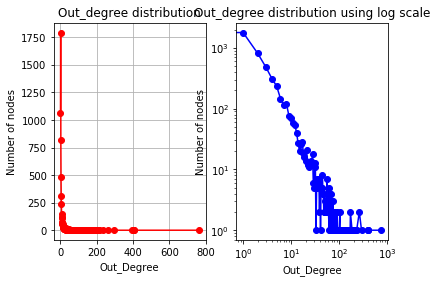

In [8]:
#Out degree distribution
outdegrees=G.out_degree()
values= sorted(set(dict(outdegrees).values()))
#print(values)
hist=[list(dict(outdegrees).values()).count(x) for x in values]

plt.figure()
plt.subplot(1,2,1)
plt.grid(True)
plt.plot(values,hist, 'ro-') 
plt.xlabel('Out_Degree')
plt.ylabel('Number of nodes')
plt.title('Out_degree distribution')
plt.subplot(1,2,2)
plt.loglog(values,hist, 'bo-')
plt.xlabel('Out_Degree')
plt.ylabel('Number of nodes')
plt.title('Out_degree distribution using log scale')
plt.show()

# Error and attack tolerance

In [378]:
#Targetted removal
def target_remov(prop, G):
    Gcco = max(nx.strongly_connected_component_subgraphs(G), key = len)
    size_Gcco = Gcco.number_of_nodes()
    CCsizes0=[len(c) for c in sorted(nx.strongly_connected_components(G), key=len,
                                    reverse=True)]
    CCsizes0.pop(0)
    if not CCsizes0 : 
        size_iso0 = 0
    else :
        size_iso0 = np.mean(CCsizes0)
    G_new = G.copy()
    sorted_nodes = sorted(nx.eigenvector_centrality(G_new).items(), key=operator.itemgetter(1),
                          reverse = True)
    nb_nodes = len(sorted_nodes)
    nb_remov = int(prop*nb_nodes)
    nodes_remov=[t[0] for t in sorted_nodes[:nb_remov]]
    G_new.remove_nodes_from(nodes_remov)
    CCsizes=[len(c) for c in sorted(nx.strongly_connected_components(G_new), key=len,
                                    reverse=True)]
    CCsizes.pop(0)
    if not CCsizes : 
        size_iso = 0
    else :
        size_iso = np.mean(CCsizes)
    Gcc = max(nx.strongly_connected_component_subgraphs(G_new), key = len)
    size_Gcc = Gcc.number_of_nodes()
    return(size_Gcc/size_Gcco, size_iso/size_iso0)

In [379]:
#Random removal
def random_remov(prop, G):
    Gcco = max(nx.strongly_connected_component_subgraphs(G), key = len)
    size_Gcco = Gcco.number_of_nodes()
    CCsizes0=[len(c) for c in sorted(nx.strongly_connected_components(G), key=len,
                                    reverse=True)]
    CCsizes0.pop(0)
    if not CCsizes0 : 
        size_iso0 = 0
    else :
        size_iso0 = np.mean(CCsizes0)
    G_new = G.copy()
    nodes = G_new.nodes()
    nb_nodes = len(nodes)
    nodes_remov=random.sample(nodes, k=int(prop*nb_nodes))
    G_new.remove_nodes_from(nodes_remov)
    CCsizes=[len(c) for c in sorted(nx.strongly_connected_components(G_new), key=len,
                                    reverse=True)]
    CCsizes.pop(0)
    if not CCsizes : 
        size_iso = 0
    else :
        size_iso = np.mean(CCsizes)
    Gcc = max(nx.strongly_connected_component_subgraphs(G_new), key = len)
    size_Gcc = Gcc.number_of_nodes()
    return(size_Gcc/size_Gcco, size_iso/size_iso0)

In [380]:
#Creating data for plots
def data_gene(propmin, propmax, nb_points, G):
    props = np.linspace(propmin, propmax, num = nb_points)
    Y_rand = []
    Y_trgt = []
    for prop in props:
        Y_rand.append(random_remov(prop,G))
        Y_trgt.append(target_remov(prop,G))
    Y_rand=np.array(Y_rand)
    Y_trgt=np.array(Y_trgt)
    return(props, Y_rand, Y_trgt)

In [381]:
props, Y_rand, Y_trgt = data_gene(0.0,0.20,30,G)

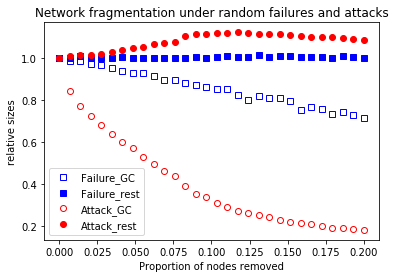

In [382]:
#Plotting the results
plt.plot(props, Y_rand[:,0], 'bs', fillstyle='none')
plt.plot(props, Y_rand[:,1],'bs')
plt.plot(props, Y_trgt[:,0], 'ro', fillstyle = 'none')
plt.plot(props, Y_trgt[:,1], 'ro')
plt.title("Network fragmentation under random failures and attacks")
plt.ylabel("relative sizes")
plt.xlabel("Proportion of nodes removed")
plt.legend(["Failure_GC","Failure_rest","Attack_GC","Attack_rest"])
plt.show()

# Modularity / clustering

In [4]:
G2 = nx.convert_node_labels_to_integers(G,label_attribute='old_label')
IDs = G2.nodes()
edges = G2.edges()


#Create directed Igraph 
g = igraph.Graph(directed=True)
g.add_vertices(IDs)
## add edges
g.add_edges(edges)

#Create undirected graph using nx
U_G=nx.to_undirected(G)

#Modularity maximisation with infomap 
p = g.community_infomap(trials=100)
Q = g.modularity(p)
print("infomap",Q)

#Create undirected Igraph 
g = igraph.Graph(directed=False)
g.add_vertices(IDs)
## add edges
g.add_edges(edges)

#Modularity maximisation with community leading eigen vector
h = g.community_leading_eigenvector()
Q1 = g.modularity(h)
print(Q1)

#Modularity maximisation with community multi level
i = g.community_multilevel(weights=None, return_levels=False)
Q2 = g.modularity(i)
print(Q2)

#Modularity maximisation with Louvain algorithm
j=community.best_partition(U_G,weight="RATING")
Q3=community.modularity(j,U_G)
print(Q3)

#Getting number of clusters
cluster =[]
for a,b in enumerate(i):
    cluster.append(b)
    
len(cluster)

infomap 0.35860873515385067
0.386523627951781
0.4845153329951179
0.21477991252214382


28

In [5]:
# dictionnary community: list of nodes
print(i[22])

[4891, 4919, 4920, 4940, 4941, 4983, 5034]


In [6]:
# Dictionary community : list of nodes
dict_max_mod={}
for item in range(len(cluster)):
    dict_max_mod[item]=i[item]

In [7]:
# dictionary node: community
dict_by_node={}
for key, value in dict_max_mod.items():
    for i in value:
        dict_by_node[i]=key

In [8]:
len(set(dict_by_node.values()))

28

Counter({3: 1407, 26: 1051, 11: 909, 9: 779, 23: 523, 10: 495, 16: 381, 14: 172, 6: 44, 18: 20, 21: 15, 2: 11, 4: 8, 24: 8, 20: 7, 22: 7, 7: 6, 8: 6, 25: 6, 19: 5, 0: 4, 1: 3, 5: 3, 17: 3, 12: 2, 13: 2, 15: 2, 27: 2})


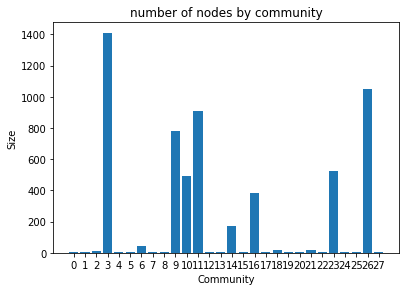

In [9]:
#Counting the number of nodes by community
from collections import Counter
counter=Counter(dict_by_node.values())
print(counter)

#count=[]
#for i in counter.values():
#    mean_scores.append(i[0])

fig = plt.figure()
axes1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#axes1.hist(dict_by_node.values() ,bins=28, label="number of nodes by community")
#axes1.set_xlabel('Community')
#axes1.set_ylabel('Size')
#axes1.set_title('number of nodes by community')

axes1.bar(range(len(set(dict_by_node.values()))), list(counter.values()), align='center')
axes1.set_xticklabels(set(dict_by_node.values()));
axes1.set_xticks(range(len(set(dict_by_node.values()))));
axes1.set_xlabel('Community')
axes1.set_ylabel("Size")
axes1.set_title("number of nodes by community");

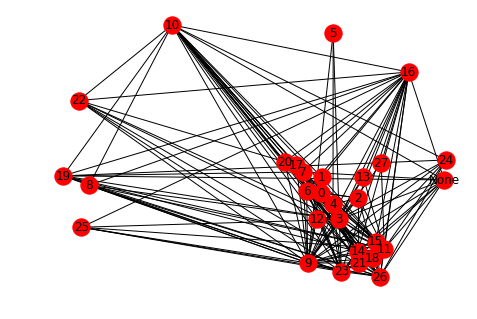

In [14]:
# A graph where each node is a community

# the function used needs to take the nodes as strings so we create a new dictionary
str_dict_by_node={}
for key, value in dict_by_node.items():
    str_dict_by_node[str(key)]=value

nodes_to_remove=[]
for key in str_dict_by_node.keys():
    if key not in list(U_G.nodes):
        nodes_to_remove.append(key)

for node in U_G.nodes():
    if node not in str_dict_by_node:
        str_dict_by_node[str(node)]=None

for key in nodes_to_remove:
    str_dict_by_node.pop(key)

ind = community.induced_graph(str_dict_by_node, U_G)

nx.draw(ind, with_labels = True) 
plt.draw() 

In [15]:
# We consider the communities that have a "significant" number of nodes
# dictionary with only nodes of considered communities
communities_of_interest=[3,6,9,10,11,14,16,23,26]
dict_commu_interest={}
for i in communities_of_interest:
    for node,commu in dict_by_node.items():
        if commu==i:
            dict_commu_interest[node]=commu

In [16]:
set(dict_commu_interest.values())

{3, 6, 9, 10, 11, 14, 16, 23, 26}

In [19]:
df2 = pd.read_csv("soc-sign-bitcoinotc.csv",header=None,names=("SOURCE TARGET RATING TIME").split())
df2.drop("TIME",axis=1,inplace=True)
df2["community_source"] = 0
df2["community_target"] = 0
df2["same_community"]=0

for i in range(df2.shape[0]):
    try:
        df2["community_source"].iloc[i]=dict_by_node[int(df2["SOURCE"].iloc[i])]
        df2["community_target"].iloc[i]=dict_by_node[int(df2["TARGET"].iloc[i])]
        if df2["community_source"].iloc[i]==df2["community_target"].iloc[i]:
            df2["same_community"].iloc[i]=1
        else:
            df2["same_community"].iloc[i]=0
    except KeyError: 
        df2["community_source"].iloc[i]=3
        df2["community_target"].iloc[i]=3
        df2["same_community"].iloc[i]=1
        
        
    if i%1000==0:print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000


In [20]:
df2.head(5)

,SOURCE,TARGET,RATING,community_source,community_target,same_community
0,6,2,4,3,3,1
1,6,5,2,3,3,1
2,1,15,1,3,3,1
3,4,3,7,3,3,1
4,13,16,8,3,9,0


In [21]:
# If two nodes are in the same community, compute their community 
community=[]
#df2["community"]='nan'
for i in range(df2.shape[0]):
    if df2["same_community"].iloc[i]==1:
        community.append(df2["community_source"].iloc[i])
    else:
        community.append("nan")
df2["community"]=community

In [22]:
df2.head(5)

,SOURCE,TARGET,RATING,community_source,community_target,same_community,community
0,6,2,4,3,3,1,3
1,6,5,2,3,3,1,3
2,1,15,1,3,3,1,3
3,4,3,7,3,3,1,3
4,13,16,8,3,9,0,nan


In [23]:
# dictionary that contains the mean rating for transactions between users of the same community and the std
dict_rating={}
dict_rating_list={}
for i in communities_of_interest:
    list_ratings=[]
    n_nodes=0
    sum_ratings=0
    for l in range(df2.shape[0]):
        if df2["same_community"].iloc[l]==1:
            if df2["community_source"].iloc[l]==i:
                sum_ratings+=df2["RATING"].iloc[l]
                list_ratings.append(df2["RATING"].iloc[l])
                n_nodes+=1
     
    dict_rating_list[i]=list_ratings
    dict_rating[i]=(sum_ratings/n_nodes,np.std(list_ratings))

In [24]:
dict_rating

{3: (1.7219605534294966, 2.5558173753041187),
 6: (2.25, 2.419538523492996),
 9: (1.1143073429220287, 3.1684644527047445),
 10: (0.592948717948718, 4.129049871765174),
 11: (1.4915824915824916, 3.5559795941409873),
 14: (0.25, 4.548351349665063),
 16: (1.1730769230769231, 3.938084041403861),
 23: (0.771551724137931, 4.011240801119523),
 26: (0.5296404275996113, 4.110280784953106)}

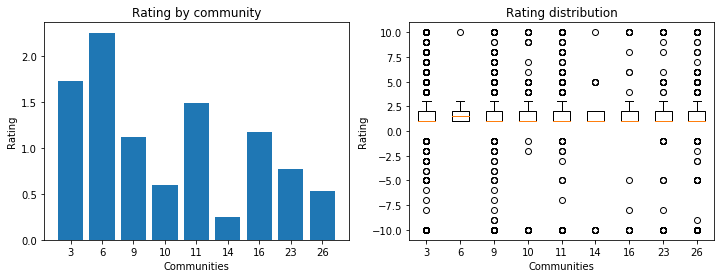

In [25]:
mean_scores=[]
for i in dict_rating.values():
    mean_scores.append(i[0])

labels, data = [*zip(*dict_rating_list.items())]  

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(len(dict_rating.keys())), mean_scores, align='center')
axes[0].set_xticklabels(list(dict_rating.keys()));
axes[0].set_xticks(range(len(dict_rating.keys())));
axes[0].set_xlabel('Communities')
axes[0].set_ylabel("Rating")
axes[0].set_title("Rating by community")


axes[1].boxplot(data)
axes[1].set_xticklabels(list(dict_rating.keys()));
axes[1].set_xticks(range(1, len(labels) + 1), labels);
axes[1].set_xlabel('Communities')
axes[1].set_ylabel("Rating")
axes[1].set_title("Rating distribution");

In [26]:
# dictionaries that store the ratios of each trust category for each community
dict_trust_3={} #dictionnary that stores the detail for community 3
dict_trust_ratio={}
dict_total_trust_ratio={}

for j in communities_of_interest:
    list_total_distrust=[]  #grades from -10 to -6
    list_distrust=[]        # grades from -5 to -1
    list_trust=[]                #grades from 1 to 5
    list_total_trust=[]     # grades from 6 to 10
    
    for i in range(df2.shape[0]):
        if df2["community"].iloc[i]==j:
            if df2["RATING"].iloc[i]<-5 and df2["RATING"].iloc[i]>-11:
                list_total_distrust.append(df2["RATING"].iloc[i])
            elif df2["RATING"].iloc[i]<0 and df2["RATING"].iloc[i]>-6:
                list_distrust.append(df2["RATING"].iloc[i])
            elif df2["RATING"].iloc[i]<6 and df2["RATING"].iloc[i]>0:
                list_trust.append(df2["RATING"].iloc[i])
            elif df2["RATING"].iloc[i]<11 and df2["RATING"].iloc[i]>5:
                list_total_trust.append(df2["RATING"].iloc[i])
    if j==3:
        dict_trust_3["total_distrust"]=len(list_total_distrust)
        dict_trust_3["distrust"]=len(list_distrust)
        dict_trust_3["trust"]=len(list_trust)
        dict_trust_3["total_trust"]=len(list_total_trust)
    
    dict_trust_ratio[j]=(len(list_trust)+len(list_total_trust))/(len(list_trust)+len(list_total_trust)+len(list_total_distrust)+len(list_distrust))
    dict_total_trust_ratio[j]=len(list_total_trust)/(len(list_trust)+len(list_total_trust)+len(list_total_distrust)+len(list_distrust))


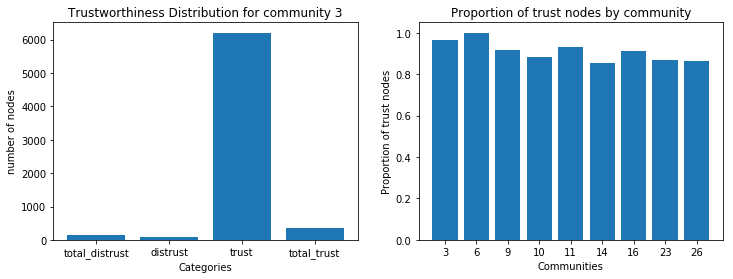

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(len(dict_trust_3)), dict_trust_3.values(), align='center')
axes[0].set_xticklabels(list(dict_trust_3.keys()));
axes[0].set_xticks(range(len(dict_trust_3.keys())));
axes[0].set_xlabel('Categories')
axes[0].set_ylabel("number of nodes")
axes[0].set_title("Trustworthiness Distribution for community 3")

axes[1].bar(range(len(dict_trust_ratio.keys())), dict_trust_ratio.values(), align='center')
axes[1].set_xticklabels(list(dict_trust_ratio.keys()));
axes[1].set_xticks(range(len(dict_trust_ratio.keys())));
axes[1].set_xlabel('Communities')
axes[1].set_ylabel("Proportion of trust nodes")
axes[1].set_title("Proportion of trust nodes by community");

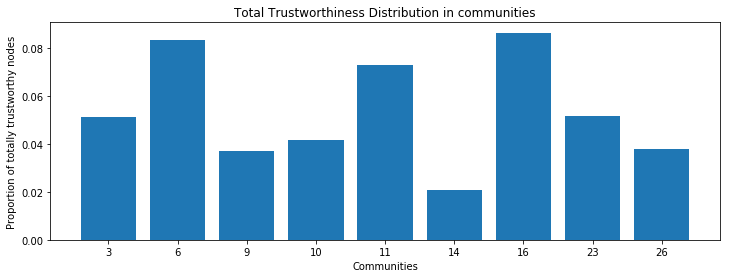

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.bar(range(len(dict_total_trust_ratio)), dict_total_trust_ratio.values(), align='center')
axes.set_xticklabels(list(dict_total_trust_ratio.keys()));
axes.set_xticks(range(len(dict_total_trust_ratio.keys())));
axes.set_xlabel('Communities')
axes.set_ylabel("Proportion of totally trustworthy nodes")
axes.set_title("Total Trustworthiness Distribution in communities");

In [31]:
df_grouped=df2.groupby(["community_source", "community_target"]).size().reset_index(name="number of edges")
df_grouped.head(5)

,community_source,community_target,number of edges
0,0,3,12
1,0,10,1
2,0,11,2
3,1,3,8
4,1,9,1


In [33]:
#dict containing the mean rating between communities
dict_inter_commu={}
for j in communities_of_interest:
    for i in range(df2.shape[0]):
        if df2["community"].iloc[i]=="nan" and df2["community_source"].iloc[i]==j:
            #print(df["community_target"].iloc[i])
            if df2["community_target"].iloc[i] in communities_of_interest:
                try:
                    dict_inter_commu[(j,df2["community_target"].iloc[i])]=dict_inter_commu[(j,df2["community_target"].iloc[i])]+ df2["RATING"].iloc[i]
                except KeyError:
                    dict_inter_commu[(j,df2["community_target"].iloc[i])]=df2["RATING"].iloc[i]

for key in dict_inter_commu.keys():
    source=key[0]
    target=key[1]
    for i in range(df_grouped.shape[0]):
        if df_grouped["community_source"].iloc[i]==source and df_grouped["community_target"].iloc[i]==target:
            dict_inter_commu[key]=dict_inter_commu[key]/df_grouped["number of edges"].iloc[i]

In [34]:
dict_inter_commu

{(3, 9): 1.3364377182770664,
 (3, 23): 1.5428907168037602,
 (3, 26): 0.4822404371584699,
 (3, 16): 0.7617728531855956,
 (3, 14): 0.27472527472527475,
 (3, 6): 1.5135135135135136,
 (3, 11): 0.46075085324232085,
 (3, 10): 0.6199524940617577,
 (6, 3): 1.6444444444444444,
 (6, 23): 1.5294117647058822,
 (6, 11): 1.0,
 (6, 9): 1.8846153846153846,
 (6, 26): 0.375,
 (6, 16): 1.3333333333333333,
 (6, 10): 3.8333333333333335,
 (6, 14): 1.5,
 (9, 3): 1.544340723453909,
 (9, 23): 0.778584392014519,
 (9, 26): -0.3793103448275862,
 (9, 16): -0.23052959501557632,
 (9, 10): -0.7323008849557522,
 (9, 6): 1.3870967741935485,
 (9, 11): 0.0011402508551881414,
 (9, 14): 0.36809815950920244,
 (10, 3): 0.9251207729468599,
 (10, 9): 0.6109510086455331,
 (10, 6): 3.8,
 (10, 26): 0.37349397590361444,
 (10, 23): 1.160220994475138,
 (10, 11): 0.714975845410628,
 (10, 16): 0.9933774834437086,
 (10, 14): 1.112,
 (11, 3): 1.3376018626309663,
 (11, 23): 1.04,
 (11, 6): -0.14285714285714285,
 (11, 9): 1.33711048158640

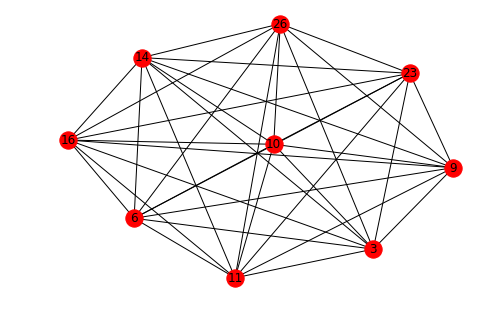

In [36]:
G_commu=nx.Graph()
for key in dict_inter_commu.keys():
    G_commu.add_weighted_edges_from([(key[0],key[1],dict_inter_commu[key])],weight="rating")

nx.draw(G_commu,with_labels = True)
plt.draw()

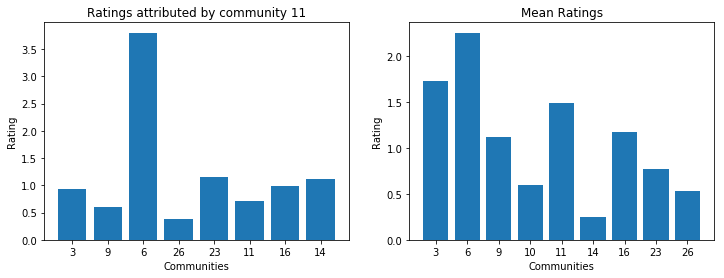

In [111]:
dict_rating_11={}
for key in dict_inter_commu.keys():
    if key[0]==10:
        dict_rating_11[key[1]]=dict_inter_commu[key]

fig, axes = plt.subplots(1,2, figsize=(12, 4))
#fig, axes = plt.subplots()
axes[0].bar(range(len(dict_rating_11.keys())), dict_rating_11.values(), align='center')
axes[0].set_xticklabels(list(dict_rating_11.keys()))
axes[0].set_xticks(range(len(dict_rating_11.keys())))
axes[0].set_xlabel('Communities')
axes[0].set_ylabel("Rating")
axes[0].set_title("Ratings attributed by community 11")

axes[1].bar(range(len(dict_rating.keys())), mean_scores, align='center')
axes[1].set_xticklabels(list(dict_rating.keys()))
axes[1].set_xticks(range(len(dict_rating.keys())))
axes[1].set_xlabel('Communities')
axes[1].set_ylabel("Rating")
axes[1].set_title("Mean Ratings");




In [86]:
dict_rating_3

{3: 1.5135135135135136,
 23: 1.0,
 6: 1.6444444444444444,
 9: 1.3870967741935485,
 10: 3.8,
 26: 2.0,
 16: 1.3333333333333333,
 14: 1.3333333333333333,
 11: -0.14285714285714285}

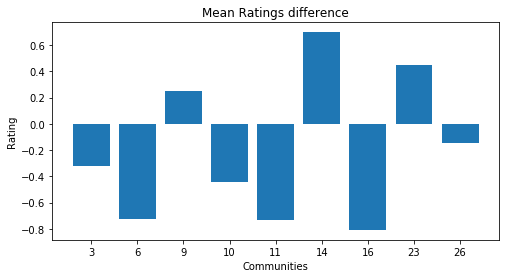

In [112]:
dict_diff_rating_inter_commu={}

for i in communities_of_interest:
    mean=0
    a=0
    for key in dict_inter_commu.keys():
        if key[1]==i:
            mean+=(dict_inter_commu[key])
            a+=1
    dict_diff_rating_inter_commu[i]=(mean/a)-dict_rating[i][0]
            

fig, axes = plt.subplots(1,1, figsize=(8, 4))
#fig, axes = plt.subplots()
axes.bar(range(len(dict_diff_rating_inter_commu.keys())), dict_diff_rating_inter_commu.values(), align='center')
axes.set_xticklabels(list(dict_diff_rating_inter_commu.keys()))
axes.set_xticks(range(len(dict_diff_rating_inter_commu.keys())))
axes.set_xlabel('Communities')
axes.set_ylabel("Rating")
axes.set_title("Mean Ratings difference");


## Using Fairness/Goodness

In [114]:
df_FG = pd.read_csv("soc-sign-bitcoinotc.csv",header=None,names=("SOURCE TARGET RATING TIME").split())
df_FG = df_FG.drop(columns = "TIME")
df_FG['RATING'] = df_FG['RATING']/10
G_FG = nx.DiGraph()
G_FG=nx.from_pandas_edgelist(df_FG, 'SOURCE','TARGET','RATING',G_FG)

In [115]:
def initiliaze_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='RATING')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness


def compute_fairness_goodness(G):
    fairness, goodness = initiliaze_scores(G)
    
    nodes = G.nodes()
    iter = 0
    while iter < 100:
        df = 0
        dg = 0

        print('-----------------')
        print("Iteration number", iter)
        
        print('Updating goodness')
        for node in nodes:
            inedges = G.in_edges(node, data='RATING')
            #print(inedges)
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        print('Updating fairness')
        for node in nodes:
            outedges = G.out_edges(node, data='RATING')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        print('Differences in fairness score and goodness score = %.2f, %.2f' % (df, dg))
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    
    return fairness, goodness

In [116]:
fairness, goodness = compute_fairness_goodness(G_FG)

-----------------
Iteration number 0
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 382.21, 0.00
-----------------
Iteration number 1
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 34.47, 102.29
-----------------
Iteration number 2
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 2.39, 6.97
-----------------
Iteration number 3
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.39, 1.06
-----------------
Iteration number 4
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.10, 0.24
-----------------
Iteration number 5
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.03, 0.06
-----------------
Iteration number 6
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.01, 0.02
-----------------
Iteration number 7
Updating good

In [120]:
df2["fairness_source"]=0
df2["goodness_source"]=0
df2["FG_source"]=0

fairness_source=[]
goodness_source=[]
FG_source=[]

for i in range(df2.shape[0]):
    fairness_source.append(fairness[df2["SOURCE"].iloc[i]])
    goodness_source.append(goodness[df2["SOURCE"].iloc[i]])
    FG_source.append(fairness_source[i]*goodness_source[i])
    
    if i%1000==0:print(i)

df2["fairness_source"]=fairness_source
df2["goodness_source"]=goodness_source
df2["FG_source"]=FG_source
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000


In [122]:
df2.head(5)

,SOURCE,TARGET,RATING,community_source,community_target,same_community,community,fairness_source,goodness_source,FG_source
0,6,2,4,3,3,1,3,0.895726,0.130176,0.116602
1,6,5,2,3,3,1,3,0.895726,0.130176,0.116602
2,1,15,1,3,3,1,3,0.922436,0.323933,0.298808
3,4,3,7,3,3,1,3,0.891287,0.286600,0.255443
4,13,16,8,3,9,0,nan,0.945563,0.167373,0.158262


{3: (0.1480650122408658, 0.0961922621034571), 6: (0.1417749090462331, 0.04644984609657157), 9: (0.11264694488262958, 0.10908362982885283), 10: (-0.014568716634952513, 0.22048112706890524), 11: (0.09237975278978941, 0.1463626801880803), 14: (0.07489253943828579, 0.18243444084465907), 16: (0.11025442977089345, 0.18713578270299652), 23: (0.12388568941053875, 0.1161666036744673), 26: (0.08457916577330803, 0.1677809476834277)}


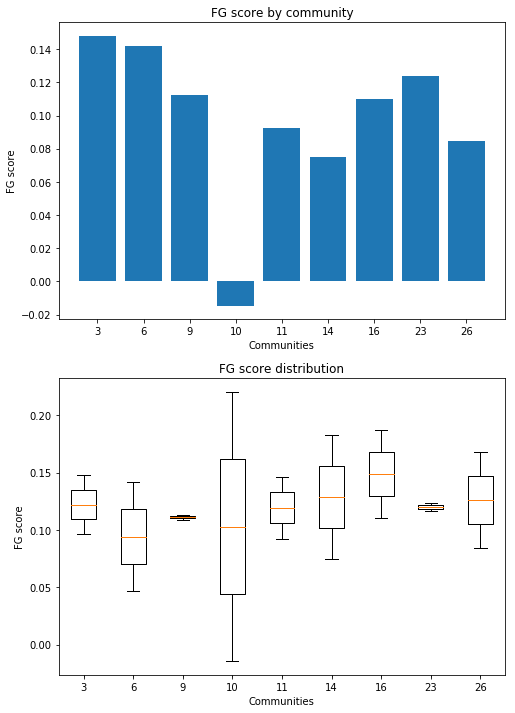

In [127]:
# dictionary that contains the mean FG score of users of the same community and the std
dict_FG={}
dict_FG_list={}
for i in communities_of_interest:
    list_ratings=[]
    n_nodes=0
    sum_ratings=0
    for l in range(df2.shape[0]):
        if df2["same_community"].iloc[l]==1:
            if df2["community_source"].iloc[l]==i:
                sum_ratings+=df2["FG_source"].iloc[l]
                list_ratings.append(df2["FG_source"].iloc[l])
                n_nodes+=1
     
    dict_FG_list[i]=list_ratings
    dict_FG[i]=(sum_ratings/n_nodes,np.std(list_ratings))

print(dict_FG)


FG_mean_scores=[]
for i in dict_FG.values():
    FG_mean_scores.append(i[0])
    
labels, data = [*zip(*dict_FG.items())] 
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

axes[0].bar(range(len(dict_FG.keys())), FG_mean_scores, align='center')
axes[0].set_xticklabels(list(dict_FG.keys()));
axes[0].set_xticks(range(len(dict_FG.keys())));
axes[0].set_xlabel('Communities')
axes[0].set_ylabel("FG score")
axes[0].set_title("FG score by community")

axes[1].boxplot(data)
axes[1].set_xticklabels(list(dict_FG.keys()));
axes[1].set_xticks(range(1, len(labels) + 1), labels);
axes[1].set_xlabel('Communities')
axes[1].set_ylabel("FG score")
axes[1].set_title("FG score distribution");

# Link predictions

In [2]:
#Put G = nx.Graph(directed = True) above (beginning of the notebook)
df = pd.read_csv("soc-sign-bitcoinotc.csv",header=None,names=("SOURCE TARGET RATING TIME").split())
df["LINK"]= 1
df = df.drop(columns = "TIME")
df = df.drop(columns = "RATING")

In [3]:
import itertools as iter
#New combination
new_comb = []
for pair in iter.combinations(df.SOURCE[0:1000].unique(), 2):
        new_comb.append(pair)

In [4]:
df2 = pd.DataFrame(new_comb, columns = ["SOURCE","TARGET"])
df2["LINK"] = 0
df = pd.concat([df,df2])
Y = df['LINK']
X = df.loc[:,df.columns!='LINK']

In [5]:
#Splitting datas between train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=2)

In [6]:
nodes = pd.concat([X.SOURCE, X.TARGET]).unique()
G_traindf = pd.concat([X_train, y_train], axis=1)
G_traindf=G_traindf[G_traindf.LINK==1]

G_traindf = G_traindf[['SOURCE', 'TARGET']]
G=nx.from_pandas_edgelist(G_traindf , 'SOURCE','TARGET')
G.add_nodes_from(nodes)
G.number_of_nodes()

5881

In [7]:
#Jaccard Similarity
jacc = []

#Adamic Similarity
adamic_adar = []

#Preferential attachment
pref_att=[]

#Common neighbors
comm_neigh = []

counter = 0
for i in range(X_train.shape[0]):
    source = X_train.iloc[i][0]
    target = X_train.iloc[i][1]


   #Topological Features
        #Preferential attachment
    deg_source = len(list(G.neighbors(source)))
    deg_target = len(list(G.neighbors(target)))
    pref_att.append(deg_source*deg_target)
    
        #Number of common neighbors
    comm_neigh.append(len(list(nx.common_neighbors(G,source,target))))
    
        #Adamic Adar
    for s,t,coeff in nx.adamic_adar_index(G,[(source, target)] ) : 
        adamic_adar.append(coeff)
    
    # Jaccard coeff
    for s,t,coeff in nx.jaccard_coefficient(G,[(source, target)] ) : 
        jacc.append(coeff)
    
    
    counter += 1
    if counter % 1000 == True:
        print(counter, "training examples processed")

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([comm_neigh, jacc,pref_att,adamic_adar]).T

# scale
training_features = preprocessing.scale(training_features)

# convert labels into integers then into column array
#labels = [int(element[2]) for element in X_train]
#labels = list(labels)
#labels_array = np.array(labels)

1 training examples processed
1001 training examples processed
2001 training examples processed
3001 training examples processed
4001 training examples processed
5001 training examples processed
6001 training examples processed
7001 training examples processed
8001 training examples processed
9001 training examples processed
10001 training examples processed
11001 training examples processed
12001 training examples processed
13001 training examples processed
14001 training examples processed
15001 training examples processed
16001 training examples processed
17001 training examples processed
18001 training examples processed
19001 training examples processed
20001 training examples processed
21001 training examples processed
22001 training examples processed
23001 training examples processed
24001 training examples processed
25001 training examples processed
26001 training examples processed
27001 training examples processed
28001 training examples processed
29001 training examples pro

In [8]:
#Jaccard Similarity
jacc = []

#Adamic Similarity
adamic_adar = []

#Preferential attachment
pref_att=[]

#Common neighbors
comm_neigh = []


counter = 0
for i in range(X_test.shape[0]):
    source = X_test.iloc[i][0]
    target = X_test.iloc[i][1]
  

   #Topological Features
        #Preferential attachment
    deg_source = len(list(G.neighbors(source)))
    deg_target = len(list(G.neighbors(target)))
    pref_att.append(deg_source*deg_target)
    
        #Number of common neighbors
    comm_neigh.append(len(list(nx.common_neighbors(G,source,target))))
        
        #Adamic Adar
    for s,t,coeff in nx.adamic_adar_index(G,[(source, target)] ) : 
        adamic_adar.append(coeff)
    
    # Jaccard coeff
    for s,t,coeff in nx.jaccard_coefficient(G,[(source, target)] ) : 
        jacc.append(coeff)
    
    
    counter += 1
    if counter % 1000 == True:
        print(counter, "testing examples processsed")

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
testing_features = np.array([comm_neigh, jacc,pref_att,adamic_adar]).T

# scale
testing_features = preprocessing.scale(testing_features)

1 testing examples processsed
1001 testing examples processsed
2001 testing examples processsed
3001 testing examples processsed
4001 testing examples processsed
5001 testing examples processsed
6001 testing examples processsed
7001 testing examples processsed
8001 testing examples processsed
9001 testing examples processsed
10001 testing examples processsed
11001 testing examples processsed
12001 testing examples processsed
13001 testing examples processsed
14001 testing examples processsed
15001 testing examples processsed
16001 testing examples processsed
17001 testing examples processsed
18001 testing examples processsed
19001 testing examples processsed


In [9]:
from sklearn import svm
from sklearn.metrics import make_scorer, accuracy_score 

linsvc_clf = svm.LinearSVC(max_iter = 20000, random_state = 112)

linsvc_clf.fit(X_train, y_train)

predtrain = linsvc_clf.predict(X_train)
acc_train = accuracy_score(y_train,predtrain)
print("The Score for LinearSVC on the train set is: " + str(acc_train))
pred_linsvc = linsvc_clf.predict(X_test)
acc_linsvc = accuracy_score(y_test, pred_linsvc)
print("The Score for LinearSVC on the test set is: " + str(acc_linsvc))

The Score for LinearSVC on the train set is: 0.8350403845737424
The Score for LinearSVC on the test set is: 0.8324575586095392


C:\Users\Arthur\Python_Projects\ML\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Weight prediction with fairness/goodness

In [345]:
def initiliaze_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='RATING')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness


def compute_fairness_goodness(G):
    fairness, goodness = initiliaze_scores(G)
    
    nodes = G.nodes()
    iter = 0
    while iter < 100:
        df = 0
        dg = 0

        print('-----------------')
        print("Iteration number", iter)
        
        print('Updating goodness')
        for node in nodes:
            inedges = G.in_edges(node, data='RATING')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        print('Updating fairness')
        for node in nodes:
            outedges = G.out_edges(node, data='RATING')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        print('Differences in fairness score and goodness score = %.2f, %.2f' % (df, dg))
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    
    return fairness, goodness

In [346]:
#Put G = nx.Graph(directed = True) above (beginning of the notebook)
df = pd.read_csv("soc-sign-bitcoinotc.csv",header=None,names=("SOURCE TARGET RATING TIME").split())
df = df.drop(columns = "TIME")
df['RATING'] = df['RATING']/10

In [347]:
Y = df['RATING']
X = df.loc[:,df.columns!='RATING']

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.5, random_state=2)

In [349]:
G_traindf = pd.concat([X_train, y_train], axis=1)

In [350]:
nodes = pd.concat([X.SOURCE, X.TARGET]).unique()
G = nx.DiGraph()

G=nx.from_pandas_edgelist(G_traindf , 'SOURCE','TARGET','RATING',G)
G.add_nodes_from(nodes)

In [291]:
# these two dictionaries have the required scores
fairness, goodness = compute_fairness_goodness(G)

-----------------
Iteration number 0
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 268.13, 0.00
-----------------
Iteration number 1
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 27.39, 76.11
-----------------
Iteration number 2
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 2.41, 6.84
-----------------
Iteration number 3
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.44, 1.19
-----------------
Iteration number 4
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.11, 0.27
-----------------
Iteration number 5
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.03, 0.07
-----------------
Iteration number 6
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.01, 0.02
-----------------
Iteration number 7
Updating goodn

In [292]:
FG =[]

counter = 0
for i in range(X_train.shape[0]):
    source = X_train.iloc[i][0]
    target = X_train.iloc[i][1]


   #TFairness Goodness
    FG.append(fairness[source] * goodness[target])
    
    
    counter += 1
    if counter % 1000 == True:
        print(counter, "training examples processed")

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([FG]).T

1 training examples processed
1001 training examples processed
2001 training examples processed
3001 training examples processed
4001 training examples processed
5001 training examples processed
6001 training examples processed
7001 training examples processed
8001 training examples processed
9001 training examples processed
10001 training examples processed
11001 training examples processed
12001 training examples processed
13001 training examples processed
14001 training examples processed
15001 training examples processed
16001 training examples processed
17001 training examples processed


In [293]:
FG =[]

counter = 0
for i in range(X_test.shape[0]):
    source = X_test.iloc[i][0]
    target = X_test.iloc[i][1]


   #TFairness Goodness
    FG.append(fairness[source] * goodness[target])
    
    
    counter += 1
    if counter % 1000 == True:
        print(counter, "training examples processed")

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([FG]).T

1 training examples processed
1001 training examples processed
2001 training examples processed
3001 training examples processed
4001 training examples processed
5001 training examples processed
6001 training examples processed
7001 training examples processed
8001 training examples processed
9001 training examples processed
10001 training examples processed
11001 training examples processed
12001 training examples processed
13001 training examples processed
14001 training examples processed
15001 training examples processed
16001 training examples processed
17001 training examples processed


In [310]:
from sklearn.linear_model import Ridge

linreg= Ridge()

parameters_linreg = {"alpha": np.logspace(-10,0,20)}

grid_linreg = GridSearchCV(linreg, parameters_linreg, scoring='neg_mean_squared_error', cv = cv_sets)
grid_linreg.fit(X_train, y_train)

linreg2 = grid_linreg.best_estimator_

linreg2.fit(X_train, y_train)
pred_linreg = linreg2.predict(X_test)
acc_linreg = math.sqrt(sklearn.metrics.mean_squared_error(y_test, pred_linreg))

print("The Score for Linear Regression is: \n rmse {0}".format(acc_linreg,))
grid_linreg.best_params_

The Score for Linear Regression is: 
 rmse 0.3531214113262192


{'alpha': 1e-10}